In [1]:
import numpy as np
from keras.layers import Conv2D, UpSampling2D, BatchNormalization
from keras.models import Sequential
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from skimage import io, transform, color
import os

from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose
from keras.models import Model
from keras.optimizers import Adam


print(f'TensorFlow {tf.__version__}')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
with tf.device('/GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0])

TensorFlow 2.10.1
Num GPUs Available:  1


In [2]:
(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0


In [3]:
# The next three methods to visualize input/output of our model side-by-side
def hstackimgs(min, max, images):
    return np.hstack(images[i] for i in range(min, max))

def sqstackimgs(length, height, images):
    return np.vstack(hstackimgs(i*length, (i+1)*length, images) for i in range(height))

def sbscompare(images1, images2, length, height):
    A = sqstackimgs(length, height, images1)
    B = sqstackimgs(length, height, images2)
    C = np.ones((A.shape[0], 32, 3))
    return np.hstack((A, C, B))

In [6]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())     # 32x32x32
model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))      # 16x16x32
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 16x16x32
model.add(BatchNormalization())     # 16x16x32
model.add(UpSampling2D())
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 32x32x32
model.add(BatchNormalization())
model.add(Conv2D(3,  kernel_size=1, strides=1, padding='same', activation='sigmoid'))   # 32x32x3

model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 up_sampling2d_2 (UpSampling  (None, 32, 32, 32)      

In [5]:
print(len(x_train))
print(len(x_train[0]))
print(len(x_train[0,0]))
print(len(x_train[0,0,0]))


50000
32
32
3


In [8]:
encoding_dim = 100  # Dimensión del espacio latente

input_shape = (32, 32, 3)
input_img = Input((input_shape))

encoded = Conv2D(1024, kernel_size=(3,3), activation='relu') (input_img)
layer1 = BatchNormalization() (encoded)
layer2 = Conv2D(512, kernel_size=(3,3), activation='relu') (layer1)
layer3 = Conv2D(256, kernel_size=(3,3), activation='relu') (layer2)
layer4 = BatchNormalization() (layer3)
layer5 = Conv2D(128, kernel_size=(3,3), activation='relu') (layer4)
layer6 = BatchNormalization() (layer5)
layer7 = Conv2D(64, kernel_size=(3,3), activation='sigmoid') (layer6)


layer8 = Conv2DTranspose(64, kernel_size=(3,3), activation='sigmoid') (layer7)
layer9 = BatchNormalization() (layer8)
layer10 = Conv2DTranspose(128, kernel_size=(3,3), activation='relu') (layer9)
layer11 = BatchNormalization() (layer10)
layer12 = Conv2DTranspose(256, kernel_size=(3,3), activation='relu') (layer11)
layer13 = Conv2DTranspose(512, kernel_size=(3,3), activation='relu') (layer12)
layer14 = BatchNormalization() (layer13)
decoded = Conv2DTranspose(1024, kernel_size=(3,3), padding='same', activation='relu') (layer14)


autoencoder = Model(inputs=[input_img], outputs=[decoded])


autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')



In [ ]:
autoencoder.fit(x_train, x_train, epochs=100, batch_size=256, shuffle=True)

In [8]:
# We want to add different noise vectors for each epoch
NOISE = 0.3     # Set to 0 for a regular (non-denoising...) autoencoder
noise = np.random.normal(0, NOISE, x_train.shape)
model.fit(x = x_train + noise, y = x_train, epochs=1000, batch_size=100)

Epoch 1/1000
500/500 [==============================] - 3s 6ms/step - loss: 0.0061 - accuracy: 0.6938
Epoch 2/1000
500/500 [==============================] - 3s 6ms/step - loss: 0.0060 - accuracy: 0.6963
Epoch 3/1000
500/500 [==============================] - 3s 6ms/step - loss: 0.0060 - accuracy: 0.6970
Epoch 4/1000
500/500 [==============================] - 3s 6ms/step - loss: 0.0060 - accuracy: 0.6974
Epoch 5/1000
500/500 [==============================] - 3s 6ms/step - loss: 0.0060 - accuracy: 0.6988
Epoch 6/1000
500/500 [==============================] - 3s 6ms/step - loss: 0.0060 - accuracy: 0.6993
Epoch 7/1000
500/500 [==============================] - 3s 6ms/step - loss: 0.0059 - accuracy: 0.7003
Epoch 8/1000
500/500 [==============================] - 3s 6ms/step - loss: 0.0059 - accuracy: 0.7017
Epoch 9/1000
500/500 [==============================] - 3s 6ms/step - loss: 0.0059 - accuracy: 0.7019
Epoch 10/1000
500/500 [==============================] - 3s 6ms/step - loss: 0.005

In [17]:
noise = np.random.normal(0, NOISE, x_train.shape)
pred_imgs = model.predict(x_train + noise)


1563/1563 [==============================] - 2s 1ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


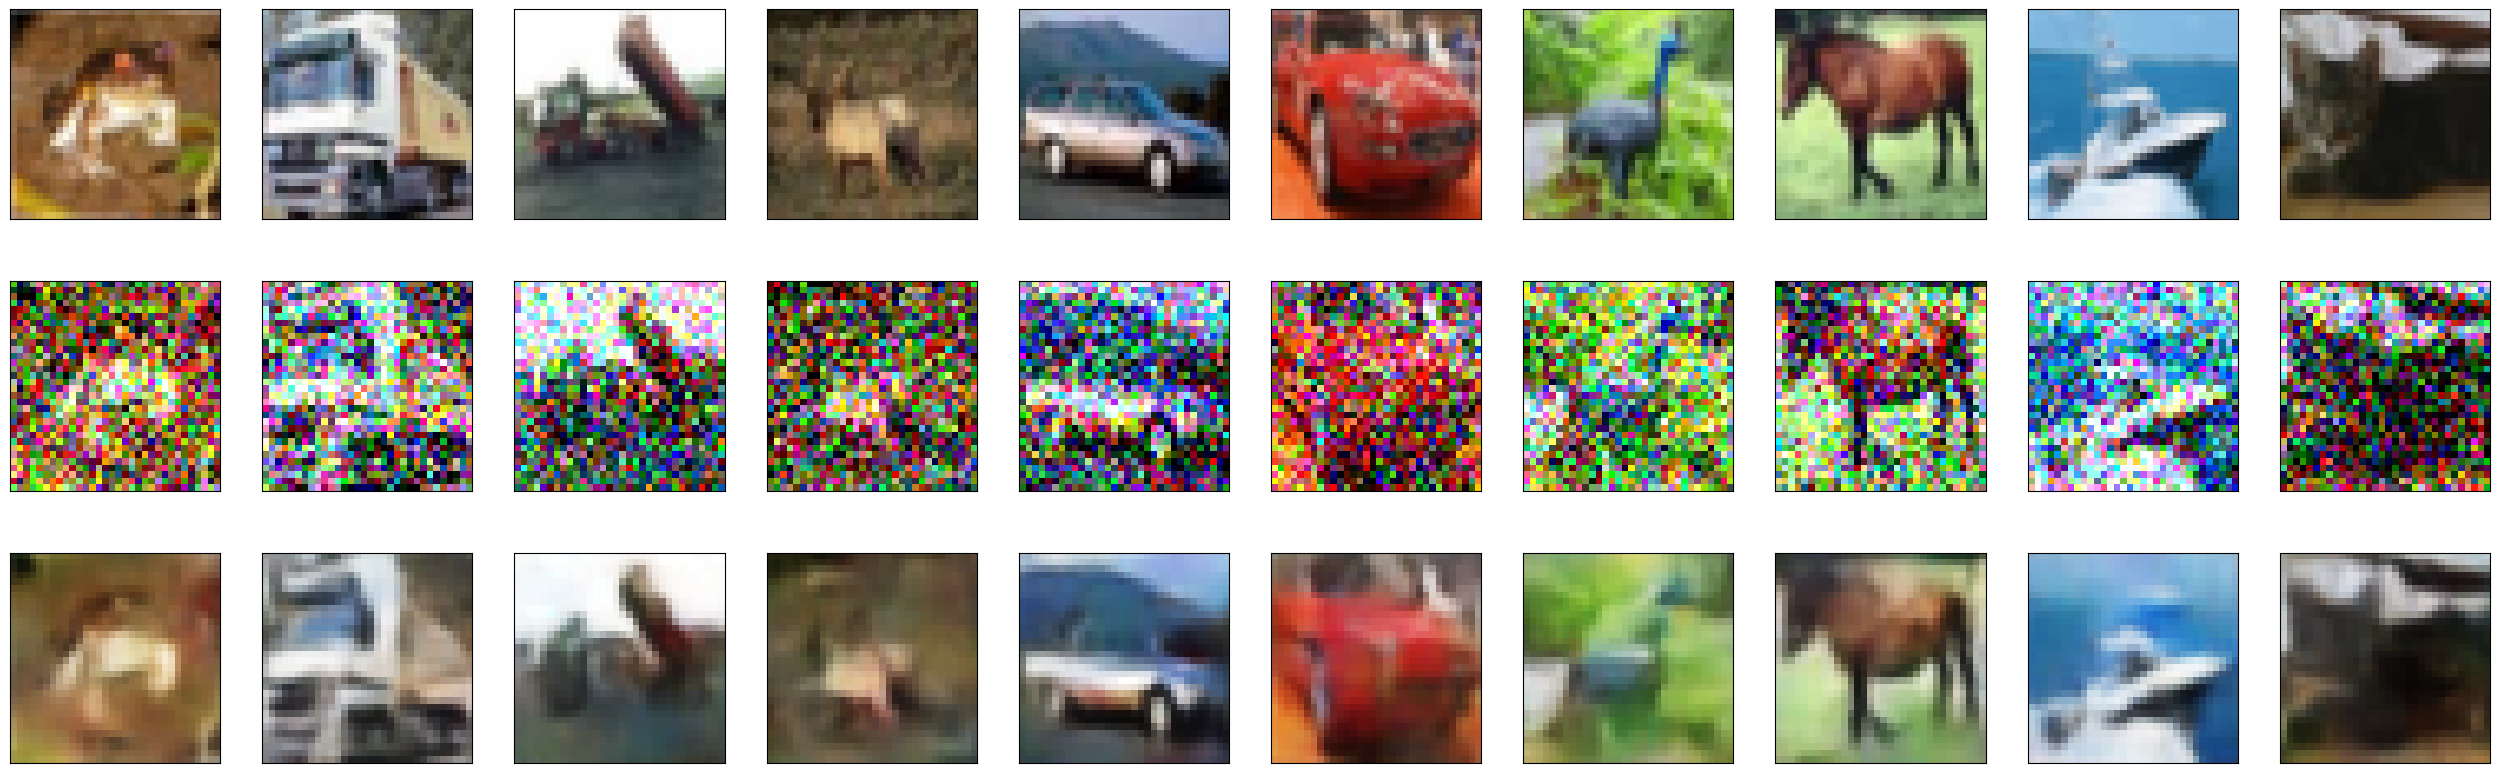

In [34]:
decoded_imgs = pred_imgs

# Visualizamos las imágenes generadas
n = 10  # Número de imágenes a mostrar
plt.figure(figsize=(32, 10))
for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_train[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen con ruido
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow((x_train[i]+noise[i]).reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen generada
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Image without noise

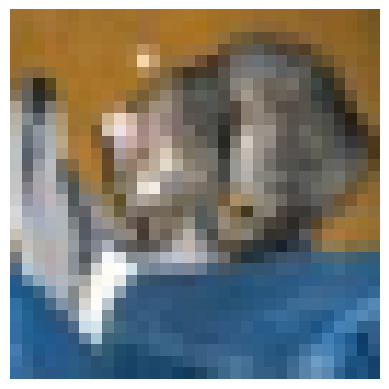

In [11]:
plt.axis('off')
plt.imshow(x_test[0], cmap='gray');

Image with noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


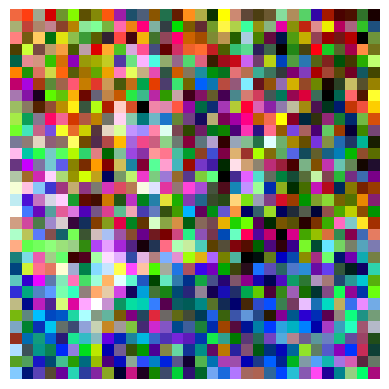

In [12]:
plt.axis('off')
plt.imshow(x_test[0]+noise[0], cmap='gray');

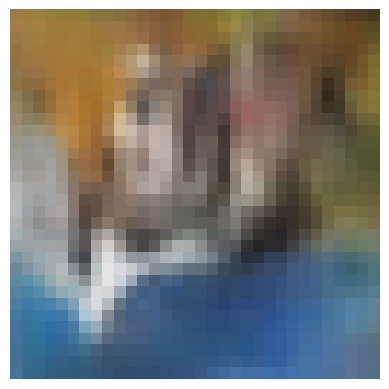

In [13]:
plt.axis('off')
plt.imshow(pred_imgs[0], cmap='gray');